<a href="https://colab.research.google.com/github/rdemarqui/sentiment_analysis/blob/main/02%20Vectorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis
## Vectorization

In [1]:
seed_value = 42

In [2]:
import multiprocessing, os, time
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn import metrics
from lightgbm import LGBMClassifier
import numpy as np
np.random.seed(seed_value)

In [3]:
path = os.getcwd()
path

'/content'

In [4]:
cores = multiprocessing.cpu_count()
cores

2

In [5]:
def vector_method_score(X_train, y_train, X_test, y_test, n_splits=5, shuffle=True, scoring='roc_auc'):
  # Check cross-validation score
  kfold = KFold(n_splits=n_splits, shuffle=shuffle, random_state=seed_value)
  model = LGBMClassifier(n_jobs=-1, verbose=-1, random_state=seed_value)
  scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
  cv_score = np.round(scores, 5)

  # Check test score
  model.fit(X_train, y_train);
  y_pred = model.predict_proba(X_test)[:,1]
  test_score = np.round(metrics.roc_auc_score(y_test, y_pred), 5)

  return cv_score, test_score

In [6]:
def pipeline(X_train, y_train, X_test, y_test, vect_function, **kwargs):
  start_time = time.time()
  dict_csv_score = {}
  dict_test_score = {}

  for preproc_method in X_train.columns:
    print(f"Running: {preproc_method}")
    X_train_vec, X_test_vec = vect_function(X_train[preproc_method], X_test[preproc_method])
    cv_score, test_score = vector_method_score(X_train_vec, y_train, X_test_vec, y_test)

    dict_csv_score[preproc_method] = cv_score
    dict_test_score[preproc_method] = [test_score]

  end_time = time.time()
  execution_time = end_time - start_time
  hours, remainder = divmod(int(execution_time), 3600)
  minutes, seconds = divmod(remainder, 60)
  print(f"\nExecution time: {hours:02d}:{minutes:02d}:{seconds:02d}")

  return dict_csv_score, dict_test_score

In [61]:
def create_score_table(cv_score, test_score, title):
  df_score = pd.DataFrame(cv_score).T
  df_score['train_mean'] = df_score.mean(axis=1)
  df_score['test'] = pd.DataFrame(test_score).T
  #df_score = df_score.style.set_caption(title)

  return df_score

## Dataset
---

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from itertools import chain

In [9]:
try:
  df = pd.read_csv(os.path.join(path, 'data\preprocessed_corpus.zip'),
                   sep=',', compression='zip')
except:
  !wget https://github.com/rdemarqui/sentiment_analysis/raw/main/data/preprocessed_corpus.zip -q
  df = pd.read_csv(os.path.join(path, 'preprocessed_corpus.zip'),
                   sep=',', compression='zip')

In [10]:
columns = ['review_text_clean', 'review_text_clean_stop', 'review_text_clean_stem',
           'review_text_clean_stop_stem', 'review_text_clean_lemma', 'review_text_clean_stop_lemma',
           'overall_rating']
corpus = df[columns].copy()
corpus['overall_rating'] = corpus['overall_rating'].apply(lambda x: 1 if x >= 4 else 0)
corpus = corpus.dropna()
print(corpus.shape)

(113005, 7)


In [11]:
# delete this line
corpus = corpus.iloc[:200, ]

In [12]:
X_train, X_test, y_train, y_test = train_test_split(corpus.iloc[:, :-1], corpus.iloc[:, -1:],
                                                    test_size=0.2, random_state=seed_value)

In [13]:
X_train.head()

,review_text_clean,review_text_clean_stop,review_text_clean_stem,review_text_clean_stop_stem,review_text_clean_lemma,review_text_clean_stop_lemma
82,otimo produto original recomendo todos podem c...,otimo produto original recomendo todos podem c...,otim produt orig recom tod pod compr praz de e...,otim produt orig recom tod pod compr praz entr...,otimo produto original recomer todo poder comp...,otimo produto original recomer todo poder comp...
201,pratico funcional facil instalacao boa ilumina...,pratico funcional facil instalacao boa iluminacao,pra func facil instalaca boa iluminaca,pra func facil instalaca boa iluminaca,praticar funcional facil instalacao boa ilumin...,praticar funcional facil instalacao boa ilumin...
40,fiquei satisfeito com seguranca garantia de to...,fiquei satisfeito seguranca garantia toda tran...,fiq satisfeit com seguranc garant de tod trans...,fiq satisfeit seguranc garant tod transaca ent...,fiquei satisfeito com seguranca garantia de to...,fiquei satisfeito seguranca garantiar todo tra...
24,otimo produto comprei para uma pessoa albina e...,otimo produto comprei pessoa albina adorou sup...,otim produt compr par uma pesso albin ele ador...,otim produt compr pesso albin ador sup lev tec,otimo produto comprar para um pessoa albino el...,otimo produto comprar pessoa albino adorar sup...
126,otima imagem som tamanho dela possibilita inst...,otima imagem som tamanho possibilita instalar ...,otim imag som tamanh del possibilit instal em ...,otim imag som tamanh possibilit instal vari ambi,otimo imagem som tamanho de ele possibilitar i...,otimo imagem som tamanho possibilitar instalar...


In [14]:
# Checking y proportion
print(f'Train proportion\n{y_train.value_counts()/y_train.shape[0]}')

Train proportion
overall_rating
1                 0.775
0                 0.225
dtype: float64


In [15]:
X_train = X_train.astype(str)
y_train = y_train.values.ravel()
X_test = X_test.astype(str)
y_test = y_test.values.ravel()

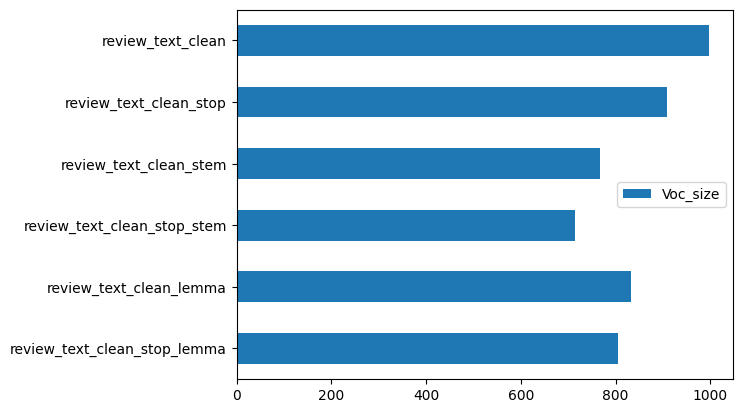

In [16]:
# Check Vocabulary size
voc_size = {}
for column in X_train.columns:
  full_text = ' '.join(X_train[column].tolist())
  words = full_text.split()
  vocabulary = set(words)
  voc_size[column] = len(vocabulary)

df_vocabulary_size = pd.DataFrame(list(voc_size.items()), columns=['Corpus', 'Voc_size'])
ax = df_vocabulary_size.plot.barh()
ax.set_yticklabels(df_vocabulary_size.Corpus)
ax.invert_yaxis();

## Sparse
---

### Bag of Word
___

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

In [18]:
def apply_bag_of_word(X_train, X_test):
  vectorizer = CountVectorizer(lowercase=False, dtype=np.float32)
  X_train_vec = vectorizer.fit_transform(X_train)
  X_test_vec = vectorizer.transform(X_test)

  return X_train_vec, X_test_vec

In [19]:
cv_score_bow, test_score_bow = pipeline(X_train, y_train, X_test, y_test,
                                        apply_bag_of_word)

Running: review_text_clean
Running: review_text_clean_stop
Running: review_text_clean_stem
Running: review_text_clean_stop_stem
Running: review_text_clean_lemma
Running: review_text_clean_stop_lemma

Execution time: 00:00:00


In [62]:
df_score_bow = create_score_table(cv_score_bow, test_score_bow, title="Bag of Word Score (ROC)")
df_score_bow

,0,1,2,3,4,train_mean,test
review_text_clean,0.94872,0.85833,0.88462,0.92188,0.91964,0.906638,0.93730
review_text_clean_stop,0.45833,0.66458,0.51603,0.68490,0.68750,0.602268,0.62382
review_text_clean_stem,0.94231,0.86667,0.93590,0.83594,0.83482,0.883128,0.90909
review_text_clean_stop_stem,0.65385,0.70833,0.56410,0.75260,0.74554,0.684884,0.71003
review_text_clean_lemma,0.91667,0.78750,0.92308,0.88542,0.91964,0.886462,0.95925
review_text_clean_stop_lemma,0.66987,0.70625,0.70192,0.71354,0.80357,0.719030,0.71160


### TF-IDF
---

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
def apply_tf_idf(X_train, X_test):
  vectorizer = TfidfVectorizer(lowercase=False, dtype=np.float32)
  X_train_vec = vectorizer.fit_transform(X_train)
  X_test_vec = vectorizer.transform(X_test)

  return X_train_vec, X_test_vec

In [23]:
cv_score_tfidf, test_score_tfidf = pipeline(X_train, y_train, X_test, y_test,
                                            apply_tf_idf)

Running: review_text_clean
Running: review_text_clean_stop
Running: review_text_clean_stem
Running: review_text_clean_stop_stem
Running: review_text_clean_lemma
Running: review_text_clean_stop_lemma

Execution time: 00:00:03


In [63]:
df_score_tfidf = create_score_table(cv_score_tfidf, test_score_tfidf, title="TF-IDF Score (ROC)")
df_score_tfidf

,0,1,2,3,4,train_mean,test
review_text_clean,0.92308,0.84583,0.91026,0.90104,0.87500,0.891042,0.95298
review_text_clean_stop,0.71795,0.56875,0.61859,0.74479,0.72768,0.675552,0.57367
review_text_clean_stem,0.94231,0.88333,0.85897,0.88542,0.90179,0.894364,0.95611
review_text_clean_stop_stem,0.74679,0.64792,0.64744,0.80469,0.82589,0.734546,0.71160
review_text_clean_lemma,0.92949,0.82083,0.85897,0.89583,0.91964,0.884952,0.95298
review_text_clean_stop_lemma,0.71474,0.57500,0.77885,0.73177,0.77232,0.714536,0.74451


## Dense
___

### Word2vec
___

In [25]:
from gensim.models import Word2Vec

In [26]:
def apply_word2vec(X_train, X_test, sg=0):
  X_train_tokenized = [text.split() for text in X_train.values.tolist()]
  X_test_tokenized = [text.split() for text in X_test.values.tolist()]

  vectorizer = Word2Vec(vector_size=300, sg=sg, workers=cores)
  vectorizer.build_vocab(X_train_tokenized)
  vectorizer.train(X_train_tokenized, total_examples=vectorizer.corpus_count, epochs=vectorizer.epochs)

  # A random vector for OOV it's better than zeros vector, because model can learn something
  vector_shape = vectorizer.wv[list(vectorizer.wv.key_to_index)[0]].shape
  np.random.seed(seed_value)
  UNK_TOKEN = np.random.rand(*vector_shape)

  def get_word_vector(word):
    return vectorizer.wv[word] if word in vectorizer.wv else UNK_TOKEN

  X_train_vec = [[get_word_vector(word) for word in text] for text in X_train_tokenized]
  X_test_vec = [[get_word_vector(word) for word in text] for text in X_test_tokenized]

  # Get mean of word vectors for each text
  X_train_vec = [np.mean(np.array(vector).T, axis=1) for vector in X_train_vec]
  X_test_vec = [np.mean(np.array(vector).T, axis=1) for vector in X_test_vec]

  return X_train_vec, X_test_vec

#### CBOW - Continuous Bag of Words
___

In [27]:
cv_score_cbow, test_score_cbow = pipeline(X_train, y_train, X_test, y_test,
                                          apply_word2vec, sg=0)

Running: review_text_clean
Running: review_text_clean_stop
Running: review_text_clean_stem
Running: review_text_clean_stop_stem
Running: review_text_clean_lemma
Running: review_text_clean_stop_lemma

Execution time: 00:00:17


In [64]:
df_score_cbow = create_score_table(cv_score_cbow, test_score_cbow, title="Word2Vec CBOW Score (ROC)")
df_score_cbow

,0,1,2,3,4,train_mean,test
review_text_clean,0.83333,0.70833,0.55769,0.51042,0.80357,0.682668,0.61912
review_text_clean_stop,0.67949,0.86250,0.60897,0.73177,0.70536,0.717618,0.69122
review_text_clean_stem,0.68590,0.59583,0.92628,0.66667,0.78571,0.732078,0.63166
review_text_clean_stop_stem,0.94872,0.48542,0.58974,0.53646,0.79464,0.670996,0.67085
review_text_clean_lemma,0.48718,0.75625,0.64423,0.67188,0.86607,0.685122,0.62069
review_text_clean_stop_lemma,0.66346,0.47917,0.50000,0.44010,0.71875,0.560296,0.56426


#### SG - Skip-Gram
___

In [29]:
cv_score_skgram, test_score_skgram = pipeline(X_train, y_train, X_test, y_test,
                                              apply_word2vec, sg=1)

Running: review_text_clean
Running: review_text_clean_stop
Running: review_text_clean_stem
Running: review_text_clean_stop_stem
Running: review_text_clean_lemma
Running: review_text_clean_stop_lemma

Execution time: 00:00:06


In [65]:
df_score_skgram = create_score_table(cv_score_skgram, test_score_skgram, title="Word2Vec Skip-gram Score (ROC)")
df_score_skgram

,0,1,2,3,4,train_mean,test
review_text_clean,0.83333,0.70833,0.55769,0.51042,0.80357,0.682668,0.61912
review_text_clean_stop,0.67949,0.86250,0.60897,0.73177,0.70536,0.717618,0.69122
review_text_clean_stem,0.68590,0.59583,0.92628,0.66667,0.78571,0.732078,0.63166
review_text_clean_stop_stem,0.94872,0.48542,0.58974,0.53646,0.79464,0.670996,0.67085
review_text_clean_lemma,0.48718,0.75625,0.64423,0.67188,0.86607,0.685122,0.62069
review_text_clean_stop_lemma,0.66346,0.47917,0.50000,0.44010,0.71875,0.560296,0.56426


### FastText
___

In [31]:
from gensim.models import FastText

In [32]:
def apply_FastText(X_train, X_test):
  X_train_tokenized = [text.split() for text in X_train.values.tolist()]
  X_test_tokenized = [text.split() for text in X_test.values.tolist()]

  vectorizer = FastText(vector_size=300, workers=cores)
  vectorizer.build_vocab(X_train_tokenized)
  vectorizer.train(X_train_tokenized, total_examples=vectorizer.corpus_count,epochs=vectorizer.epochs)

  # A random vector for OOV it's better than zeros vector, because model can learn something
  vector_shape = vectorizer.wv[list(vectorizer.wv.key_to_index)[0]].shape
  np.random.seed(seed_value)
  UNK_TOKEN = np.random.rand(*vector_shape)

  def get_word_vector(word):
    return vectorizer.wv[word] if word in vectorizer.wv else UNK_TOKEN

  X_train_vec = [[get_word_vector(word) for word in text] for text in X_train_tokenized]
  X_test_vec = [[get_word_vector(word) for word in text] for text in X_test_tokenized]

  # Get mean of word vectors for each text
  X_train_vec = [np.mean(np.array(vector).T, axis=1) for vector in X_train_vec]
  X_test_vec = [np.mean(np.array(vector).T, axis=1) for vector in X_test_vec]

  return X_train_vec, X_test_vec

In [33]:
cv_score_FastTest, test_score_FastTest = pipeline(X_train, y_train, X_test, y_test,
                                                  apply_FastText)

Running: review_text_clean
Running: review_text_clean_stop
Running: review_text_clean_stem
Running: review_text_clean_stop_stem
Running: review_text_clean_lemma
Running: review_text_clean_stop_lemma

Execution time: 00:00:20


In [66]:
df_score_FastTest = create_score_table(cv_score_FastTest, test_score_FastTest, title="FastTest Score (ROC)")
df_score_FastTest

,0,1,2,3,4,train_mean,test
review_text_clean,0.78846,0.77917,0.83333,0.75521,0.94643,0.820520,0.98746
review_text_clean_stop,0.80769,0.86667,0.72436,0.88021,0.89286,0.834358,0.78683
review_text_clean_stem,0.87821,0.70000,0.76282,0.83333,0.72321,0.779514,0.90596
review_text_clean_stop_stem,0.89103,0.81250,0.77564,0.87500,0.89286,0.849406,0.85266
review_text_clean_lemma,0.87821,0.87917,0.96795,0.79167,0.93750,0.890900,0.82132
review_text_clean_stop_lemma,0.83974,0.77083,0.85256,0.79688,0.89286,0.830574,0.73354


### Doc2Vec
___

In [35]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

In [36]:
def apply_doc2vec(X_train, X_test, dm=0):
  X_train_tagged = [TaggedDocument(words=text.split(), tags=[str(i)]) for i, text in enumerate(X_train.values.tolist())]
  X_test_tokenized = [text.split() for text in X_test.values.tolist()]

  vectorizer = Doc2Vec(vector_size=300, workers=cores, dm=dm)
  vectorizer.build_vocab(X_train_tagged)
  vectorizer.train(X_train_tagged, total_examples=vectorizer.corpus_count, epochs=vectorizer.epochs)

  X_train_vec = [vectorizer.dv[tag] for tag in vectorizer.dv.index_to_key]
  X_test_vec = [vectorizer.infer_vector(text) for text in X_test_tokenized]

  return X_train_vec, X_test_vec

#### DBOW - Distributed Bag of Words
___

In [37]:
cv_score_dbow, test_score_dbow = pipeline(X_train, y_train, X_test, y_test,
                                          apply_doc2vec, dm=0)

Running: review_text_clean
Running: review_text_clean_stop
Running: review_text_clean_stem
Running: review_text_clean_stop_stem
Running: review_text_clean_lemma
Running: review_text_clean_stop_lemma

Execution time: 00:00:05


In [67]:
df_score_dbow = create_score_table(cv_score_dbow, test_score_dbow, title="Doc2Vec DBOW Score (ROC)")
df_score_dbow

,0,1,2,3,4,train_mean,test
review_text_clean,0.57051,0.55833,0.67949,0.55208,0.58036,0.588154,0.63009
review_text_clean_stop,0.39744,0.46667,0.46154,0.60938,0.47321,0.481648,0.36677
review_text_clean_stem,0.58974,0.62083,0.75641,0.66146,0.53571,0.632830,0.60188
review_text_clean_stop_stem,0.40385,0.44167,0.50000,0.43229,0.42857,0.441276,0.66458
review_text_clean_lemma,0.64744,0.69167,0.64744,0.70312,0.48214,0.634362,0.60815
review_text_clean_stop_lemma,0.37179,0.48333,0.51923,0.55208,0.41071,0.467428,0.52978


#### DM - Distributed Memory
___

In [39]:
cv_score_dm, test_score_dm = pipeline(X_train, y_train, X_test, y_test,
                                      apply_doc2vec, dm=1)

Running: review_text_clean
Running: review_text_clean_stop
Running: review_text_clean_stem
Running: review_text_clean_stop_stem
Running: review_text_clean_lemma
Running: review_text_clean_stop_lemma

Execution time: 00:00:03


In [68]:
df_score_dm = create_score_table(cv_score_dm, test_score_dm, title="Doc2Vec DM Score (ROC)")
df_score_dm

,0,1,2,3,4,train_mean,test
review_text_clean,0.57051,0.55833,0.67949,0.55208,0.58036,0.588154,0.63009
review_text_clean_stop,0.39744,0.46667,0.46154,0.60938,0.47321,0.481648,0.36677
review_text_clean_stem,0.58974,0.62083,0.75641,0.66146,0.53571,0.632830,0.60188
review_text_clean_stop_stem,0.40385,0.44167,0.50000,0.43229,0.42857,0.441276,0.66458
review_text_clean_lemma,0.64744,0.69167,0.64744,0.70312,0.48214,0.634362,0.60815
review_text_clean_stop_lemma,0.37179,0.48333,0.51923,0.55208,0.41071,0.467428,0.52978


### Transformer (Pre-trained model)
___

#### Bert

**Note 1:** In this stage, it's important that Colab uses `GPU`instead of `CPU`.

**Note 2:** As already said in https://huggingface.co/blog/how-to-train-sentence-transformers, pre-trained transformers are slow to perform the task (even using GPU), so we decided to run in a small portion of data. It's results won't be used in the final conclusions. For transformes it's better to use sentence transfomers, available in Hugging Face (next topic).

**Note 3:** As expected Bert performed better with text without remove stop words, stematize and lemmatize.

In [41]:
!pip install transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.9 MB/s eta 0:00:00


In [42]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [43]:
from transformers import AutoModel
from transformers import AutoTokenizer

In [44]:
model = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased').to(device)
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=True)

In [45]:
def apply_tranformer(X_train, X_test, model=model, tokenizer=tokenizer):
  model = model
  tokenizer = tokenizer

  X_train_list = X_train.values.tolist()
  X_test_list = X_test.values.tolist()

  # Get tokens form text
  X_train_toc = [tokenizer.encode(doc, return_tensors='pt').to(device) for doc in X_train_list]
  X_test_toc = [tokenizer.encode(doc, return_tensors='pt').to(device) for doc in X_test_list]

  # Get mean vectors from converted tokens ([0, 1:-1] Last layer, ignore [CLS] and [SEP] special tokens)
  with torch.no_grad():
    X_train_vec = [torch.mean(model(tokens)[0][0, 1:-1].T, dim=1).cpu().data.numpy() for tokens in X_train_toc]
    X_test_vec = [torch.mean(model(tokens)[0][0, 1:-1].T, dim=1).cpu().data.numpy() for tokens in X_test_toc]

  return X_train_vec, X_test_vec

In [46]:
# Testing with reduced data
cv_score_bert, test_score_bert = pipeline(X_train.iloc[:100, :], y_train[:100],
                                          X_test.iloc[:100, :], y_test[:100],
                                          apply_tranformer,
                                          model=model,
                                          tokenizer=tokenizer)

Running: review_text_clean
Running: review_text_clean_stop
Running: review_text_clean_stem
Running: review_text_clean_stop_stem
Running: review_text_clean_lemma
Running: review_text_clean_stop_lemma

Execution time: 00:00:32


In [69]:
df_score_bert = create_score_table(cv_score_bert, test_score_bert, title="BERT Score (ROC)")
df_score_bert

,0,1,2,3,4,train_mean,test
review_text_clean,0.96429,0.95312,0.90110,0.84314,0.73684,0.879698,0.86520
review_text_clean_stop,0.79762,0.85938,0.92308,0.88235,0.52632,0.797750,0.86207
review_text_clean_stem,0.92857,0.71875,0.86813,0.62745,0.78947,0.786474,0.84326
review_text_clean_stop_stem,0.83333,0.96875,1.00000,0.66667,1.00000,0.893750,0.79937
review_text_clean_lemma,0.97619,0.96875,0.86813,0.92157,0.78947,0.904822,0.89342
review_text_clean_stop_lemma,0.77381,0.92188,0.92308,0.82353,0.68421,0.825302,0.87774


#### Sentence Transformer

**Note:** In this stage, it's important that Colab uses `GPU`instead of `CPU`.

In [48]:
device = !nvidia-smi -L
device = "cuda" if device[0][:3] == 'GPU' else "cpu"
device

'cuda'

In [49]:
!pip install sentence_transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.6 MB/s eta 0:00:00


In [50]:
from sentence_transformers import SentenceTransformer

In [51]:
model=SentenceTransformer('rufimelo/bert-large-portuguese-cased-sts', device=device)

In [52]:
def apply_sentece_transformer(X_train, X_test, model=model):
  model = model
  X_train_list = X_train.values.tolist()
  X_test_list = X_test.values.tolist()

  X_train_vec = model.encode(X_train_list)
  X_test_vec = model.encode(X_test_list)

  return X_train_vec, X_test_vec

In [53]:
cv_score_st, test_score_st = pipeline(X_train.iloc[:100, :], y_train[:100],
                                      X_test.iloc[:100, :], y_test[:100],
                                      apply_sentece_transformer,
                                      model=model)

Running: review_text_clean
Running: review_text_clean_stop
Running: review_text_clean_stem
Running: review_text_clean_stop_stem
Running: review_text_clean_lemma
Running: review_text_clean_stop_lemma

Execution time: 00:00:33


In [141]:
df_score_st = create_score_table(cv_score_st, test_score_st, title="Sentence Transformer Score (ROC)")
df_score_st

,0,1,2,3,4,train_mean,test
review_text_clean,1.00000,0.96875,0.97802,0.92157,0.84211,0.942090,0.96865
review_text_clean_stop,0.95238,0.93750,0.87912,0.84314,0.52632,0.827692,0.84326
review_text_clean_stem,1.00000,0.78125,0.92308,0.74510,0.73684,0.837254,0.95925
review_text_clean_stop_stem,0.86905,0.95312,1.00000,0.66667,0.42105,0.781978,0.86834
review_text_clean_lemma,0.96429,1.00000,0.96703,0.82353,0.89474,0.929918,0.85266
review_text_clean_stop_lemma,0.82143,0.92188,0.95604,0.88235,0.42105,0.800550,0.95611


## Results Analysis

In [155]:
import seaborn as sns
sns.set(style="whitegrid")

In [90]:
df_scores = {'Bag of Words': df_score_bow, 'TF-IDF':df_score_tfidf, 'W2V CBOW':df_score_cbow,
             'W2V Skip-Gram':df_score_skgram, 'FastTest':df_score_FastTest, 'D2V DBOW':df_score_dbow,
             'D2V DM':df_score_dm, 'Bert':df_score_bert, 'Sent. Transf.':df_score_st}

In [144]:
# Grouping all test results
df_scores_vect = pd.DataFrame()
for key in df_scores.keys():
  df_scores_vect[key] = df_scores[key]['test'].values
text_type = list(df_score_st.index.values)
df_scores_vect = df_scores_vect.rename(index=dict(zip(df_scores_vect.index, text_type)))

df_scores_vect

,Bag of Words,TF-IDF,W2V CBOW,W2V Skip-Gram,FastTest,D2V DBOW,D2V DM,Bert,Sent. Transf.
review_text_clean,0.93730,0.95298,0.61912,0.61912,0.98746,0.63009,0.63009,0.86520,0.96865
review_text_clean_stop,0.62382,0.57367,0.69122,0.69122,0.78683,0.36677,0.36677,0.86207,0.84326
review_text_clean_stem,0.90909,0.95611,0.63166,0.63166,0.90596,0.60188,0.60188,0.84326,0.95925
review_text_clean_stop_stem,0.71003,0.71160,0.67085,0.67085,0.85266,0.66458,0.66458,0.79937,0.86834
review_text_clean_lemma,0.95925,0.95298,0.62069,0.62069,0.82132,0.60815,0.60815,0.89342,0.85266
review_text_clean_stop_lemma,0.71160,0.74451,0.56426,0.56426,0.73354,0.52978,0.52978,0.87774,0.95611


[]

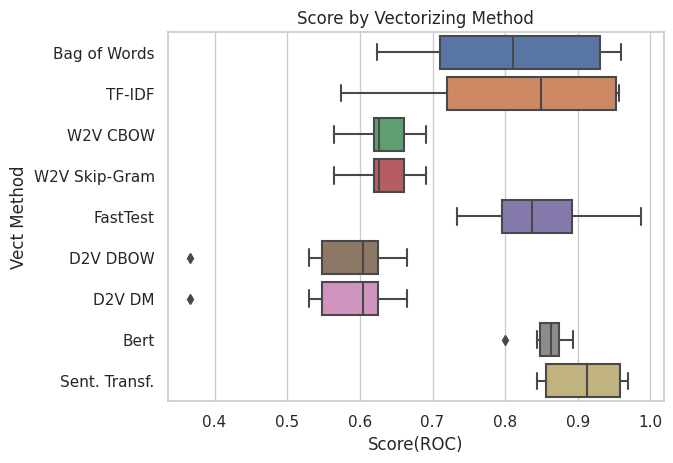

In [152]:
columns_name = {'level_0':'Text Type', 'level_1': 'Vect Method', 0: 'Score(ROC)'}
df_scores_vect_stack = df_scores_vect.stack().reset_index().rename(columns=columns_name)
ax = sns.boxplot(x='Score(ROC)', #'Vect Method'
                 y='Vect Method', # 'Score(ROC)'
                 data=df_scores_vect_stack, orient='h')
#ax.set_xticklabels(ax.get_xticklabels()), rotation=90)
plt.title('Score by Vectorizing Method')
plt.plot()

[]

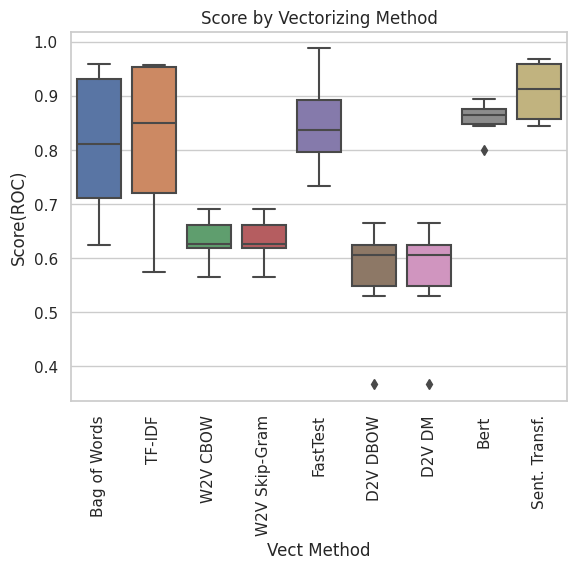

In [154]:
columns_name = {'level_0':'Text Type', 'level_1': 'Vect Method', 0: 'Score(ROC)'}
df_scores_vect_stack = df_scores_vect.stack().reset_index().rename(columns=columns_name)
df_scores_vect_stack['Vect Method & Text'] =  df_scores_vect_stack['Vect Method'] + ' ' + df_scores_vect_stack['Text Type']

ax = sns.boxplot(x='Vect Method',
                 y='Score(ROC)',
                 data=df_scores_vect_stack)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Score by Vectorizing Method')
plt.plot()

[]

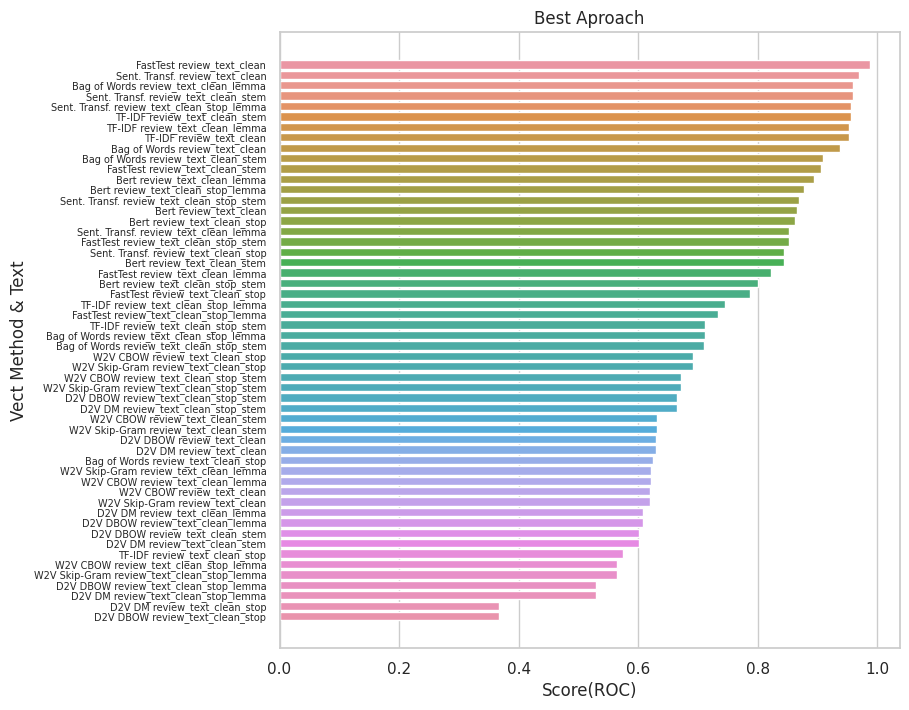

In [165]:
plt.figure(figsize=(8, 8))
ax = sns.barplot(x='Score(ROC)', y='Vect Method & Text',
                 data=df_scores_vect_stack.sort_values(by='Score(ROC)', ascending=False),
                 orient='h')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)
plt.title('Best Aproach')
plt.plot()

[]

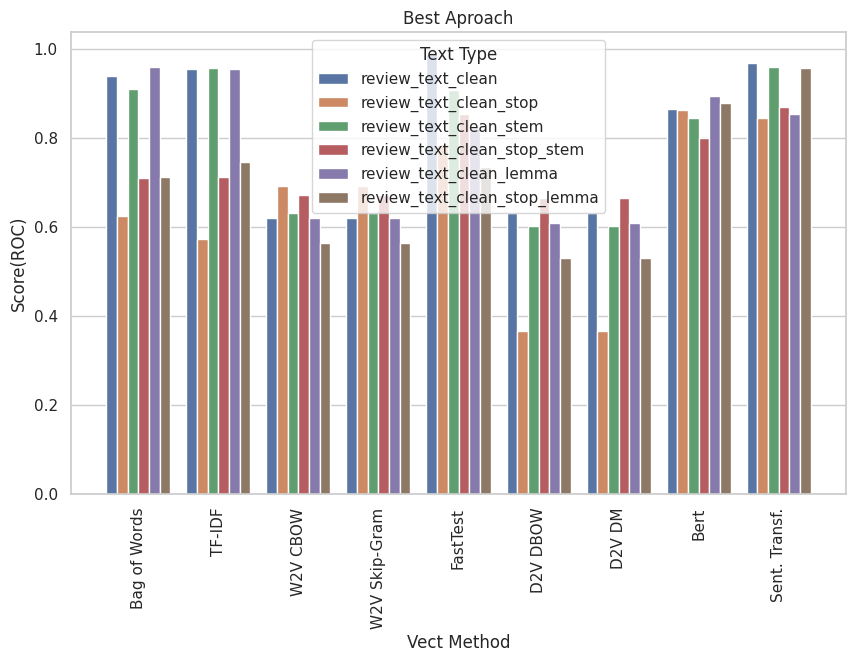

In [170]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Vect Method', y='Score(ROC)',
                 hue='Text Type',
                 data=df_scores_vect_stack,
                 )
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title('Best Aproach')
plt.plot()

In [166]:
df_scores_vect_stack

,Text Type,Vect Method,Score(ROC),Vect Method & Text
0,review_text_clean,Bag of Words,0.93730,Bag of Words review_text_clean
1,review_text_clean,TF-IDF,0.95298,TF-IDF review_text_clean
2,review_text_clean,W2V CBOW,0.61912,W2V CBOW review_text_clean
3,review_text_clean,W2V Skip-Gram,0.61912,W2V Skip-Gram review_text_clean
4,review_text_clean,FastTest,0.98746,FastTest review_text_clean
5,review_text_clean,D2V DBOW,0.63009,D2V DBOW review_text_clean
6,review_text_clean,D2V DM,0.63009,D2V DM review_text_clean
7,review_text_clean,Bert,0.86520,Bert review_text_clean
8,review_text_clean,Sent. Transf.,0.96865,Sent. Transf. review_text_clean
9,review_text_clean_stop,Bag of Words,0.62382,Bag of Words review_text_clean_stop
